In [6]:
import os
import sys

# Add the src directory to the sys.path
try:
    # Try using __file__ in a script
    current_dir = os.path.dirname(__file__)
except NameError:
    # Use current working directory in Jupyter notebooks
    current_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(os.path.join(current_dir, 'src'))

# import libraries
import fire
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential

from data_loader import TimeSeriesDataloader
from hybrid import LSTM_SSM, process_input_ssm


In [7]:
# Define parameters
num_epochs = 30
batch_size = 1
sigma_v = 1
output_col = [0]
num_features = 5
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

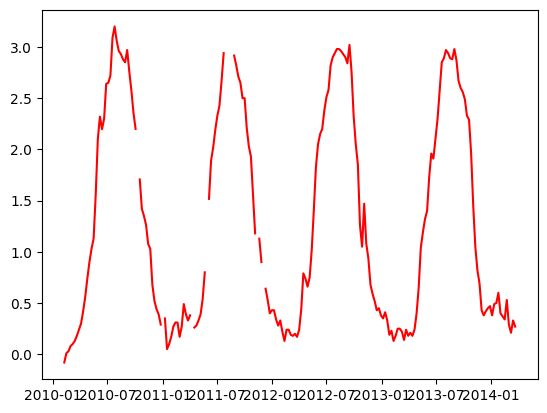

In [24]:
# Dataset
data_file = "../data/HQ/LGA007PIAP-E010_Y_train.csv"
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)

# Time
time_file = "../data/HQ/LGA007PIAP-E010_Y_train_datetime.csv"
time = pd.read_csv(time_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(time[0], format='%Y-%m-%d %H:%M:%S')

# plotting
plt.figure()
plt.plot(time, df.values[:,output_col], color='r')

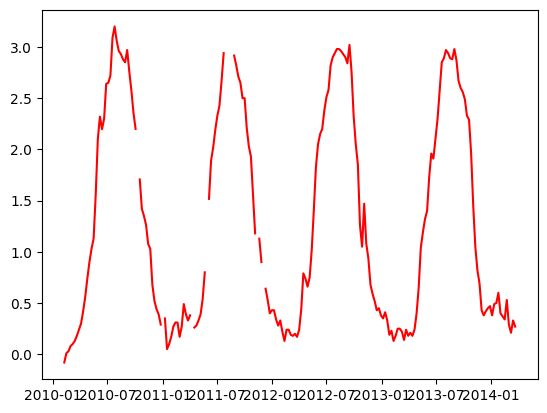

In [14]:
df

,0,1,2,3
0,-0.08,31.15,-16.3,-7.4
1,0.01,30.94,-9.1,0.6
2,0.03,31.07,-6.0,2.0
3,0.08,31.04,-0.1,5.0
4,0.10,31.04,-5.9,9.2
...,...,...,...,...
211,0.53,31.06,-4.3,3.9
212,0.29,30.99,-21.5,-8.4
213,0.21,31.10,-11.6,0.6
214,0.33,31.02,-11.8,3.6
